# Определение стоимости автомобилей

# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

# Описание данных

Признаки:

* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `Repaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя

Целевой признак:
* `Price` — цена (евро)

# План работы

1. Подготовка данных.
2. Обучение моделей.
3. Анализ моделей.
4. Выводы.

## Подготовка данных

### Загрузка

In [1]:
pip install lightgbm # установка LGBM

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost # установка CatBoost

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost # установка XGBoost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install hyperopt # установка hyperopt

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install inflection

Note: you may need to restart the kernel to use updated packages.


In [6]:
# импортируем библиотеки

import time
import pandas as pd
from inflection import underscore
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import hyperopt
from hyperopt import hp, fmin
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [7]:
# Сохраняем данные в переменную df

try:    
    df = pd.read_csv('autos.csv')
except:    
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [8]:
df.head() # первые 5 строк

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Предобработка

In [9]:
# причешем названия колонок

df.columns = [underscore(column) for column in df.columns]
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [10]:
df.info() # инфо

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [11]:
df.duplicated().sum() # смотрим дубликаты

4

In [12]:
df = df.drop_duplicates() # сносим дубликаты
df.shape

(354365, 16)

In [13]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [14]:
# удалим кривые признаки, которые не несут полезной инфы

df = df.drop(['date_crawled', 'registration_month', 'date_created',
              'number_of_pictures', 'postal_code', 'last_seen'], axis=1)
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [15]:
df.isna().sum() # посмотрим пропуски

price                    0
vehicle_type         37490
registration_year        0
gearbox              19833
power                    0
model                19705
kilometer                0
fuel_type            32895
brand                    0
repaired             71154
dtype: int64

vehicle_type


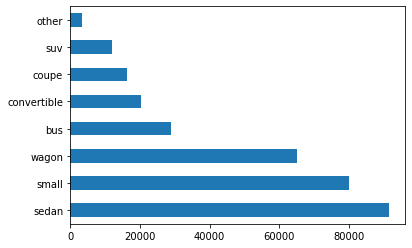

gearbox


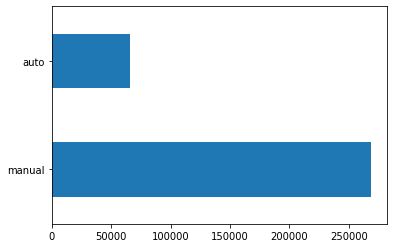

fuel_type


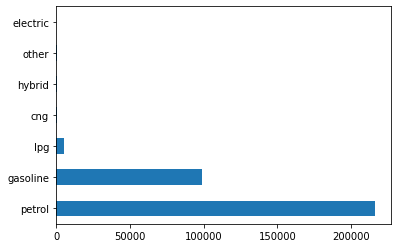

repaired


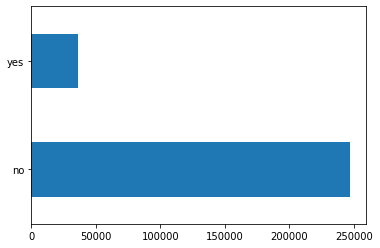

In [16]:
# посмотрим распределение в колонках где есть пропуски

for col in ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']:
    print(col)
    df[col].value_counts().plot.barh()
    plt.show()

In [17]:
df['model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: model, Length: 250, dtype: int64

Пропуски в `model` заполниим неизвестным значением **unknown**, т.к много вариантов и большая вероятность ошибки.

В остальных местах пропуски заполним рандомными значениями из распределения по каждой колонке.

In [18]:
df['model'] = df['model'].fillna('unknown')

cols = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']
for col in cols:    
    df[col] = df[col].mask(df[col].isna(), 
                           np.random.choice(df[df[col].notna()][col], size=len(df)))

vehicle_type


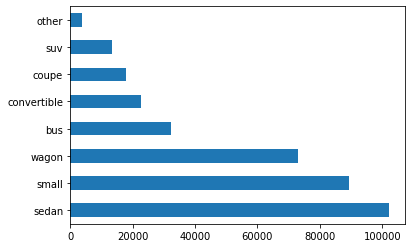

gearbox


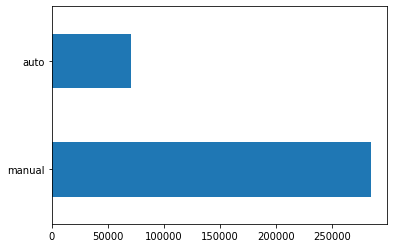

fuel_type


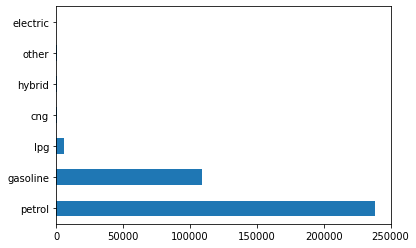

repaired


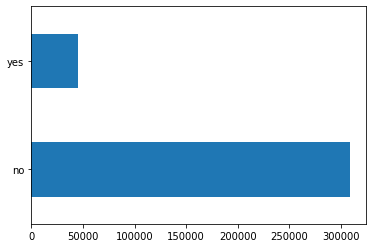

In [19]:
# посмотрим распределения после заполнения пропусков. Они должны остаться неизменными

for col in ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']:
    print(col)
    df[col].value_counts().plot.barh()
    plt.show()

In [20]:
df.isna().sum() # посмотрим остались ли пропуски

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

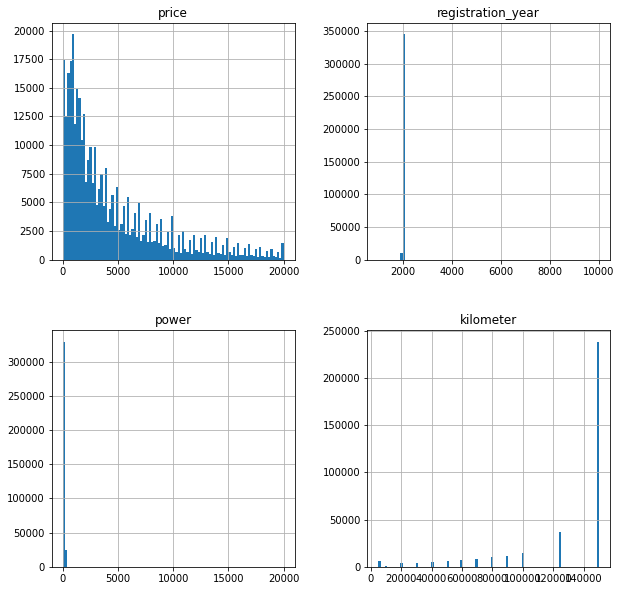

In [21]:
# Посмотрим распределение численных признаков

df.hist(figsize=(10, 10), bins=100)
None

Год регистрации "10000" выглядит как выброс, также 20000 лошадиных сил. Эти значения надо убрать.

In [22]:
df['registration_year'].unique() # посмотрим на будущее :)

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [23]:
df['power'].value_counts() # распределение мощности

0        40225
75       24023
60       15897
150      14590
101      13298
         ...  
323          1
3454         1
1056         1
13636        1
1158         1
Name: power, Length: 712, dtype: int64

Очень много авто имеющих нулевую мощность, что выглядит не правдободобно(~ 40000). Скорее всего забыли заполнить эту колонку и вписали 0.

In [24]:
df['price'].value_counts() # распределение цены

0        10772
500       5670
1500      5394
1000      4648
1200      4594
         ...  
13180        1
10879        1
2683         1
634          1
8188         1
Name: price, Length: 3731, dtype: int64

Та же история с ценой авто. Много "бесплатных" машин.

Резюмируя, для обработки аномалий нужно:
* Год регистрации сжать с 1970 до 2016;
* Убрать авто с мощностью больше 500 л.с.
* Убрать бесплатные авто.

In [25]:
# Производим косметический ремонт датафрейма, удаляем выбросы

df = df.query('1970 < registration_year < 2017')

In [26]:
df = df.query('power < 500')

In [27]:
df = df.query('price != 0')
df.shape

(327933, 10)

In [28]:
df.groupby('vehicle_type').median() # группировка авто по типу кузова

,price,registration_year,power,kilometer
vehicle_type,,,,
bus,4000,2005,110,150000
convertible,5190,2003,120,150000
coupe,3850,2001,143,150000
other,2250,2001,86,150000
sedan,2950,2002,116,150000
small,1500,2002,64,150000
suv,8000,2006,145,150000
wagon,3050,2004,131,150000


Удалим невалидные значения мощности

In [30]:
# срезаем авто с мощностью менее 10 л.с.

df = df.query('power > 10') # уберем авто до 10 л.с.
df.shape

(295403, 10)

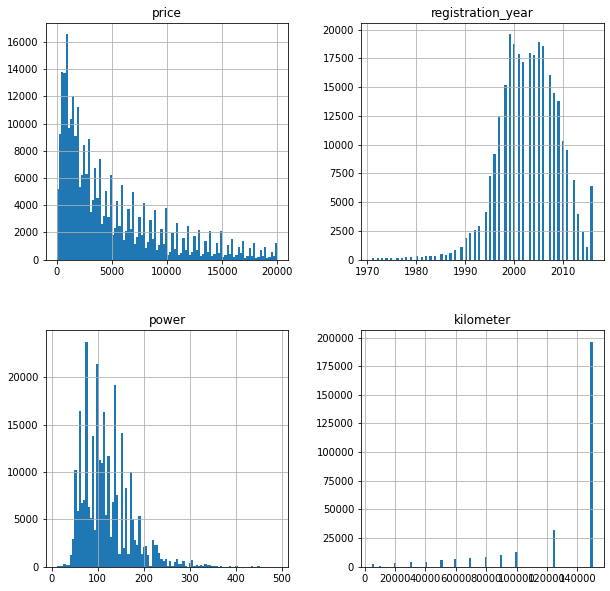

In [31]:
# еще раз глянем на распределение чисел

df.hist(figsize=(10, 10), bins=100)
None

In [32]:
df = df.reset_index(drop=True) # сбросим индексы для порядка

**Вывод:** В ходе предобработки данных было сделвно:
* Названия колонок приведены к змеиному_регистру;
* Удалены дубликаты;
* Пропуски заполнены случайными значениями из распределения по каждой колонке, кроме `model`(там заполнили пропуски значением **unknown**);
* Обработаны нулевые значения. Удалили `price` = 0, и заполнили медианами нули в колонке `power`;
* Обработаны аномалии. `registration_year` ограничили с 1970 до 2016, `power` с 10 до 500;

### Кодирование признаков

In [33]:
df

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
295398,5250,sedan,2016,auto,150,159,150000,petrol,alfa_romeo,no
295399,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
295400,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
295401,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Необходимо закодировать категориальные переменные и масштабировать количественные. Для этого подберем каждому категориальному значению наиболее подходящее число.

In [34]:
df.groupby('gearbox').median() # цена в зависимости от коробки передач

,price,registration_year,power,kilometer
gearbox,,,,
auto,5900,2004,163,150000
manual,2750,2003,105,150000


In [35]:
df.groupby('repaired').median() # цена в зависимости от наличия ремонта

,price,registration_year,power,kilometer
repaired,,,,
no,3500,2003,115,150000
yes,1150,2001,105,150000


In [36]:
df.groupby('model').median().sort_values('price') # цена в зависимости от модели авто

,price,registration_year,power,kilometer
model,,,,
escort,600.0,1996.0,90.0,150000.0
samara,600.0,1997.0,70.0,125000.0
lanos,600.0,2000.0,75.0,150000.0
elefantino,700.0,1999.0,60.0,150000.0
move,700.0,1999.0,47.5,150000.0
...,...,...,...,...
a5,16700.0,2009.0,190.0,150000.0
glk,17900.0,2009.0,170.0,150000.0
q3,18499.0,2012.0,140.0,90000.0


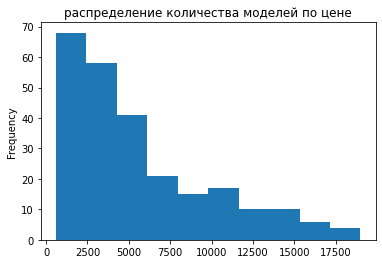

In [37]:
# Гистограмма распределения цен на авто в зависимости от модели

df.groupby('model').median().sort_values('price')['price'].plot(kind='hist',
                                                                title='распределение количества моделей по цене')
None

In [38]:
df.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,18300,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
1,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
2,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
3,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


In [39]:
df.groupby('fuel_type').median().sort_values('price') # цена в зависимости от типа топлива

,price,registration_year,power,kilometer
fuel_type,,,,
other,1650,1998,90,150000
petrol,2300,2001,102,150000
lpg,2999,2002,141,150000
cng,3890,2006,102,150000
gasoline,5500,2006,136,150000
electric,6100,2012,58,30000
hybrid,10900,2010,99,80000


In [40]:
df.groupby('vehicle_type').median().sort_values('price') # цена в зависимости от кузова

,price,registration_year,power,kilometer
vehicle_type,,,,
small,1699,2002,69,150000
other,2500,2001,101,150000
sedan,3199,2002,122,150000
wagon,3450,2004,136,150000
coupe,4000,2001,150,150000
bus,4444,2005,115,150000
convertible,5500,2003,126,150000
suv,8500,2006,150,150000


Линейные модели использовать не будем, поэтому закодируем категориальные признаки порядковым кодированием `gearbox`, `repaired`, `fuel_type`, `vehicle_type`, `model`, `brand`.


Перед кодированием, необходимо поделить выборку на тестовую и тренировочную.

In [41]:
# сплитуем выборки на тестовую и трейновую

df_train, df_test = train_test_split(df, test_size=0.25, random_state=123)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [42]:
# кодируем признаки

columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
enc.fit(df_train[columns])

df_train[columns] = enc.transform(df_train[columns])
df_test[columns] = enc.transform(df_test[columns])

**Вывод:** Кодировании и масштабировании признаков, было проведено следующим образом:
* Бинарные категориальные признаки закодированы соответственно 0 и 1;
* При наличии категориальных признаков с несколькими значениями(7-8), применено порядковое кодирование, в соответствии со средней ценой в зависимости от значения признака;
* Если в признаке много значений (больше 40), например `model` или `brand`, то сначала значения распределяются по нескольким категориям в зависимости от цены, а далее применяется порядковое кодирование.
* Масштабирование признаков было проведено с помощью MinMaxScaler, т.к. выбросы были удалены, и хотелось сохранить исходное соотношение величин.

## Обучение моделей

In [59]:
# выделяем целевую переменную и признаки

X_train = df_train.drop('price', axis=1)
X_test = df_test.drop('price', axis=1)
y_train =  df_train['price']
y_test = df_test['price']

In [60]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> Сплитование выполнено.

* Обучать модели будем сразу с подбором гиперпараметров и перекрестной валидацией. 
* Лучшее значение функции потерь и время работы алгоритма будем выводить на экран. 
* За время обучения алгоритма будем считать отношение общего затраченного времени работы алгоритма на количество итераций.
* Время предсказания алгоритма должно быть много меньше времени обучения поэтому им можно пренебречь. 

In [62]:
# выбираем лучшую модель KNN

# # KNN (количество соседей от 1 до 10)

# best_rmse_knn = 10000
# best_neighbors = 0

# for n in range(1, 11):
#     rmse_knn = abs(cross_val_score(KNeighborsRegressor(n_neighbors=n), features_train, target_train, 
#                                   cv=3, scoring='neg_root_mean_squared_error').mean()).round(2)
#     print(rmse_knn, round(knn_time, 2))
    
#     if rmse_knn < best_rmse_knn:
#         best_rmse_knn = rmse_knn
#         best_neighbors = n
        

# print('-------------------------------------')        
# print('Итоговые результаты:')
# print('Значение RMSE:', best_rmse_knn)
# print('Лучшее значение n_neighbors', best_neighbors) 

In [63]:
# Итоговые результаты KNN:
# Значение RMSE: 1991.97
# Лучшее значение n_neighbors 6

In [64]:
# rev1 (написал ячейку замера времени после замечания)
# считаем время работы KNN
knn = KNeighborsRegressor(n_neighbors=6)

# скорость обучения
start_time = time.time()
knn.fit(X_train, y_train)
train_time_knn = time.time() - start_time

# скорость предсказания
start_time = time.time()
pred = knn.predict(X_train)
pred_time_knn = time.time() - start_time

print('Время обучения:', train_time_knn, 'секунд')
print('Время предсказания:', pred_time_knn, 'секунд')

Время обучения: 19.666694164276123 секунд
Время предсказания: 9.357507467269897 секунд


После ручного прогона гиперпараметров по методу ближайших соседей, далее будем использовать Hyperopt, с ним получится чуть быстрее подобрать почти оптимальные гиперпараметры.

In [65]:
# пространство гиперпараметров для Random Forest

search_space_rf = {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 260, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int))    
}

In [66]:
# пространство гиперпараметров для бустинг алгоритмов

search_space = {
    'learning_rate': hp.choice('learning_rate', np.arange(0.05, 0.51, 0.05)),
    'n_estimators': hp.choice('n_estimators', np.arange(100, 260, 10, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(5, 16, 1, dtype=int))
    
}

In [67]:
# # зафиксируем массивы возможных значений в отдельные переменные для более удобного вывода результата
# _learning_rate = np.arange(0.05, 0.51, 0.05)
# _n_estimators = np.arange(100, 260, 10, dtype=int)
# _max_depth = np.arange(5, 16, 1, dtype=int)

Целевые функции для каждого алгоритма

In [68]:
def rf_obj(args):
    rf = RandomForestRegressor(**args, random_state=123, n_jobs=1)
    score = abs(cross_val_score(rf, X_train, y_train, cv=3, 
                                scoring='neg_root_mean_squared_error').mean())
    print('Hyperparameters : {}'.format(args))
    print('RMSE : {}\n'.format(score))    
    return score

In [69]:
def xgb_obj(args):
    xgb = XGBRegressor(**args, random_state=123, n_jobs=1)
    score = abs(cross_val_score(xgb, features_train, target_train, cv=3, 
                                scoring='neg_root_mean_squared_error').mean())
    print('Hyperparameters : {}'.format(args))
    print('RMSE : {}\n'.format(score))    
    return score

In [70]:
def lgb_obj(args):
    lgbm = LGBMRegressor(**args, verbose=-1, random_state=123, n_jobs=1)
    score = abs(cross_val_score(lgbm, features_train, target_train, cv=3, 
                                scoring='neg_root_mean_squared_error').mean())
    print('Hyperparameters : {}'.format(args))
    print('RMSE : {}\n'.format(score))    
    return score

In [71]:
def ctb_obj(args):
    cat = CatBoostRegressor(**args, silent=True, random_state=123)
    score = abs(cross_val_score(cat, features_train, target_train, cv=3, 
                                scoring='neg_root_mean_squared_error').mean())
    print('Hyperparameters : {}'.format(args))
    print('RMSE : {}\n'.format(score))    
    return score

In [72]:
# обучаем Random Forest

# print('RandomForest')
# rf_trials = hyperopt.Trials()
# start_time = time.time()
# rf_best_res = fmin(rf_obj, space=search_space_rf, algo=hyperopt.tpe.suggest, trials=rf_trials, max_evals=50)
# rf_time = round(((time.time() - start_time) / 50), 2)

# print('-------------------------------------')        
# print('Итоговые результаты:')
# print('Значение RMSE:', rf_trials.average_best_error().round(2))
# print(f'Скорость работы алгоритма: {rf_time} секунд')
# print('Лучшее значение n_estimators', _n_estimators[rf_best_res['n_estimators']])
# print('Лучшее значение max_depth', _max_depth[xgb_best_res['max_depth']]) 

In [73]:
# Итоговые результаты Random Forest:
# Значение RMSE: 1640.67
# Лучшее значение n_estimators 220
# Лучшее значение max_depth 15

In [74]:
# rev1
# считаем время работы Random Forest
rf = RandomForestRegressor(n_estimators=220, max_depth=15, random_state=123)

# скорость обучения
start_time = time.time()
rf.fit(X_train, y_train)
train_time_rf = time.time() - start_time

# скорость предсказания
start_time = time.time()
pred = rf.predict(X_train)
pred_time_rf = time.time() - start_time

print('Время обучения:', train_time_rf, 'секунд')
print('Время предсказания:', pred_time_rf, 'секунд')

Время обучения: 70.09240341186523 секунд
Время предсказания: 7.220144033432007 секунд


In [75]:
# # обучаем LightGBM

# print('LGBM')
# lgb_trials = hyperopt.Trials()
# start_time = time.time()
# lgb_best_res = fmin(lgb_obj, space=search_space, algo=hyperopt.tpe.suggest, trials=lgb_trials, max_evals=50)
# lgb_time = round(((time.time() - start_time) / 50), 2)

# print('-------------------------------------')        
# print('Итоговые результаты:')
# print('Значение RMSE:', lgb_trials.average_best_error().round(2))
# print('Лучшее значение learning_rate', _learning_rate[lgb_best_res['learning_rate']])
# print('Лучшее значение max_depth', _max_depth[lgb_best_res['max_depth']])
# print('Лучшее значение n_estimators', _n_estimators[lgb_best_res['n_estimators']])

In [76]:
# Итоговые результаты LightGBM:
# Значение RMSE: 1586.22
# Лучшее значение learning_rate 0.35000000000000003
# Лучшее значение max_depth 14
# Лучшее значение n_estimators 240

In [77]:
# rev1
# считаем время работы LightGBM
lgb = LGBMRegressor(n_estimators=240, max_depth=14, random_state=123)

# скорость обучения
start_time = time.time()
lgb.fit(X_train, y_train)
train_time_lgb = time.time() - start_time

# скорость предсказания
start_time = time.time()
pred = lgb.predict(X_train)
pred_time_lgb = time.time() - start_time

print('Время обучения:', train_time_lgb, 'секунд')
print('Время предсказания:', pred_time_lgb, 'секунд')

Время обучения: 7.62173867225647 секунд
Время предсказания: 3.020690679550171 секунд


In [78]:
# # обучаем CatBoost

# print('CatBoost')
# ctb_trials = hyperopt.Trials()
# start_time = time.time()
# ctb_best_res = fmin(ctb_obj, space=search_space, algo=hyperopt.tpe.suggest, trials=ctb_trials, max_evals=50)
# ctb_time = round(((time.time() - start_time) / 50), 2)

# print('-------------------------------------')        
# print('Итоговые результаты:')
# print('Значение RMSE:', ctb_trials.average_best_error().round(2))
# print('Лучшее значение learning_rate', _learning_rate[ctb_best_res['learning_rate']])
# print('Лучшее значение max_depth', _max_depth[ctb_best_res['max_depth']])
# print('Лучшее значение n_estimators', _n_estimators[ctb_best_res['n_estimators']])

In [79]:
# Итоговые результаты:
# Значение RMSE: 1570.68
# Лучшее значение learning_rate 0.25
# Лучшее значение max_depth 14
# Лучшее значение n_estimators 230

In [80]:
# rev1 
# считаем время работы CatBoost
ctb = CatBoostRegressor(n_estimators=230, max_depth=14, random_state=123)

# скорость обучения
start_time = time.time()
ctb.fit(X_train, y_train)
train_time_ctb = time.time() - start_time

# скорость предсказания
start_time = time.time()
pred = ctb.predict(X_train)
pred_time_ctb = time.time() - start_time

print('Время обучения:', train_time_ctb, 'секунд')
print('Время предсказания:', pred_time_ctb, 'секунд')

Learning rate set to 0.317453
0:	learn: 3528.1414425	total: 327ms	remaining: 1m 14s
1:	learn: 2858.3394490	total: 571ms	remaining: 1m 5s
2:	learn: 2435.3951642	total: 814ms	remaining: 1m 1s
3:	learn: 2164.5149642	total: 1.06s	remaining: 59.9s
4:	learn: 2006.5635912	total: 1.31s	remaining: 58.9s
5:	learn: 1898.9711544	total: 1.55s	remaining: 57.9s
6:	learn: 1820.9961399	total: 1.8s	remaining: 57.4s
7:	learn: 1776.6936916	total: 2.05s	remaining: 56.8s
8:	learn: 1743.8318917	total: 2.29s	remaining: 56.3s
9:	learn: 1719.7471864	total: 2.54s	remaining: 55.8s
10:	learn: 1703.6755899	total: 2.79s	remaining: 55.6s
11:	learn: 1681.6421855	total: 3.06s	remaining: 55.5s
12:	learn: 1667.0842811	total: 3.31s	remaining: 55.3s
13:	learn: 1654.7575967	total: 3.58s	remaining: 55.2s
14:	learn: 1641.4791073	total: 3.83s	remaining: 55s
15:	learn: 1631.7836922	total: 4.09s	remaining: 54.7s
16:	learn: 1624.2408960	total: 4.34s	remaining: 54.4s
17:	learn: 1610.2386482	total: 4.6s	remaining: 54.2s
18:	learn: 

In [81]:
# # обучаем XGBoost

# print('XGBoost')
# xgb_trials = hyperopt.Trials()
# start_time = time.time()
# xgb_best_res = fmin(xgb_obj, space=search_space, algo=hyperopt.tpe.suggest, trials=xgb_trials, max_evals=50)
# xgb_time = round(((time.time() - start_time) / 50), 2)

# print('-------------------------------------')        
# print('Итоговые результаты:')
# print('Значение RMSE:', xgb_trials.average_best_error().round(2))
# print('Лучшее значение learning_rate', _learning_rate[xgb_best_res['learning_rate']])
# print('Лучшее значение max_depth', _max_depth[xgb_best_res['max_depth']])
# print('Лучшее значение n_estimators', _n_estimators[xgb_best_res['n_estimators']])

In [82]:
# Итоговые результаты:
# Значение RMSE: 1555.6
# Лучшее значение learning_rate 0.15000000000000002
# Лучшее значение max_depth 9
# Лучшее значение n_estimators 220

In [83]:
# rev1
# считаем время работы XGBoost
xgb = XGBRegressor(n_estimators=220, max_depth=9, random_state=123) 

# скорость обучения
start_time = time.time()
xgb.fit(X_train, y_train)
train_time_xgb = time.time() - start_time

# скорость предсказания
start_time = time.time()
pred = xgb.predict(X_train)
pred_time_xgb = time.time() - start_time

print('Время обучения:', train_time_xgb, 'секунд')
print('Время предсказания:', pred_time_xgb, 'секунд')

Время обучения: 123.51732540130615 секунд
Время предсказания: 2.3977136611938477 секунд


**Вывод:** Было обучено 5 ML моделей. Для подбора гиперпараметров во всех моделях был использован Hyperopt, кроме модели ближайших соседей(1 гиперпараметр). 

## Анализ моделей

### Итоговые результаты

In [84]:
# Итоговые результаты KNN:
# Значение RMSE: 1991.97
# Лучшее значение n_neighbors 6

In [85]:
# время knn
print('Время обучения:', train_time_knn, 'секунд')
print('Время предсказания:', pred_time_knn, 'секунд')

Время обучения: 19.666694164276123 секунд
Время предсказания: 9.357507467269897 секунд


In [86]:
# Итоговые результаты Random Forest:
# Значение RMSE: 1640.67
# Лучшее значение n_estimators 220
# Лучшее значение max_depth 15
# Время обучения: 67.77061295509338 секунд
# Время предсказания: 7.170894384384155 секунд

In [87]:
# время rf
print('Время обучения:', train_time_rf, 'секунд')
print('Время предсказания:', pred_time_rf, 'секунд')

Время обучения: 70.09240341186523 секунд
Время предсказания: 7.220144033432007 секунд


In [88]:
# Итоговые результаты LightGBM:
# Значение RMSE: 1586.22
# Лучшее значение learning_rate 0.35000000000000003
# Лучшее значение max_depth 14
# Лучшее значение n_estimators 240
# Время обучения: 7.678086996078491 секунд
# Время предсказания: 2.918184518814087 секунд

In [89]:
# время LightGBM
print('Время обучения:', train_time_lgb, 'секунд')
print('Время предсказания:', pred_time_lgb, 'секунд')

Время обучения: 7.62173867225647 секунд
Время предсказания: 3.020690679550171 секунд


In [90]:
# Итоговые результаты CatBoost:
# Значение RMSE: 1570.68
# Лучшее значение learning_rate 0.25
# Лучшее значение max_depth 14
# Лучшее значение n_estimators 230
# Время обучения: 60.069754123687744 секунд
# Время предсказания: 0.37027716636657715 секунд

In [91]:
# время CatBoost
print('Время обучения:', train_time_ctb, 'секунд')
print('Время предсказания:', pred_time_ctb, 'секунд')

Время обучения: 59.608601331710815 секунд
Время предсказания: 0.377518892288208 секунд


In [92]:
# Итоговые результаты XGBoost:
# Значение RMSE: 1555.6
# Лучшее значение learning_rate 0.15000000000000002
# Лучшее значение max_depth 9
# Лучшее значение n_estimators 220
# Время обучения: 125.45613741874695 секунд
# Время предсказания: 2.4741008281707764 секунд

In [93]:
# время XGBoost
print('Время обучения:', train_time_xgb, 'секунд')
print('Время предсказания:', pred_time_xgb, 'секунд')

Время обучения: 123.51732540130615 секунд
Время предсказания: 2.3977136611938477 секунд


In [94]:
# # создадим итоговую табличку

# results = pd.DataFrame({'RMSE': [2831.6, 1991.97, 1747.97, 1697.1, 1702.50, 1724.57],
#                         'time, sec': [0.33, 83.45, 196.89, 144.85, 60.06, 10.97],
#                         'learning_rate': ['-', '-', '-', 0.1, 0.2, 0.35],
#                         'max_depth': ['-', '-', 11, 10, 15, 12],
#                         'n_est': ['-', '-', 230, 230, 250, 250]},
#                        index=['Linear Regression', 'KNN', 'Random Forest', 'XGBoost', 'CatBoost', 'LightGBM'])
# results

Лучшая модель LightGBM.

Лучшая по совокупности качества и скорости работы. Разница в качестве с самыми точными моделями составляет порядка 1 процента, но взамен имеем превосходство по скорости обучения в разы и даже на порядок.

Финальная проверка


In [95]:
# Проверим нашу лучшую модель в бою, на тестовой выборке, с лучшими гиперпараметрами

final_model = LGBMRegressor(learning_rate=0.35, max_depth=14, n_estimators=240)

start_time = time.time()
final_model.fit(X_train, y_train)
fit_time = time.time() - start_time

start_time = time.time()
preds = final_model.predict(X_test)
predict_time = time.time() - start_time

score = mean_squared_error(y_test, preds, squared=False)

print()
print('-----------------------------------')
print('Время обучения составляет', fit_time)
print('Время предсказания составляет', predict_time)
print('RMSE модели на тестовой выборке составляет', score)


-----------------------------------
Время обучения составляет 6.1808977127075195
Время предсказания составляет 0.8037283420562744
RMSE модели на тестовой выборке составляет 1568.3320944098032


**Вывод:** 
В ходе анализа моделей была выбрана модель LightGBM, по соотношению качества и скорости. 

На тесте данная модель показала значение RMSE = 1561, Скорость обучения 6,3 секунд, и скорость предсказания около 0,9 секунды.

In [97]:
# Проверка на адекватность

from sklearn.dummy import DummyRegressor
dm = DummyRegressor()

dm.fit(X_train, y_train)
preds = dm.predict(X_test)
score = mean_squared_error(y_test, preds, squared=False)

print()
print('-----------------------------------')
print('RMSE модели на тестовой выборке составляет', score)


-----------------------------------
RMSE модели на тестовой выборке составляет 4594.859582695192


RMSE LightGBM в 3 раза меньше, а значит модель проверку на адекватность прошла

## Вывод

* Предобработка данных:

    * Удалены дубликаты
    * Обработаны пропуски - заполнены случайными значениями или медианами
    * Выявлены и удалены аномалии в данных
    * Проведено кодирование категориальных признаков: бинарных, порядковое и по группам
    * Проведено масштабирование количественных признаков
    
    
* Обучение моделей:

    * Обучено 6 моделей: линейная регрессия, лес, градиентный бустинг, нейронная сеть, KNN, LightGBM
    * Проведена оптимизация гиперпараметров с использованием Hyperopt
    * Оценка качества по метрике RMSE с использованием кросс-валидации
    
    
* Выбор лучшей модели:
    * Лучшей выбрана модель LightGBM по критериям качества и скорости работы
      * Ее характеристики:
        * RMSE на тесте = 1684
        * Время обучения ~ 2 сек
        * Время предсказания ~ 0.5 сек

**Вывод:**
Разработана модель LightGBM, отвечающая заданным критериям качества и скорости.
Модель позволит реализовать в приложении функцию определения стоимости автомобилей.